# Upload and transform data

Download CSV from yahoo finance https://finance.yahoo.com/quote/SPY/history?p=SPY&period1=728317800&period2=1714750717

In [1]:
from google.colab import files
uploaded=files.upload()

Saving SPY.csv to SPY.csv


In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=8b0a2051c9785caed1afdcc0025f66d98cfb757e314d7d8ec8f36a03a79e96c6
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [3]:
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# Initialize scaler
scaler = MinMaxScaler()

# Load the dataset
data = pd.read_csv('SPY.csv', parse_dates=['Date'], index_col='Date')

# Calculate Simple Moving Averages (SMA)
data['SMA_9'] = data['Close'].rolling(window=9).mean()
data['SMA_18'] = data['Close'].rolling(window=18).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()

# Comparison of SMAs
data['9>18'] = (data['SMA_9'] > data['SMA_18']).astype(int)
data['50>200'] = (data['SMA_50'] > data['SMA_200']).astype(int)

# Initialize and calculate the Parabolic SAR
data['SAR'] = ta.trend.PSARIndicator(high=data['High'], low=data['Low'], close=data['Close'], step=0.02, max_step=0.2).psar()


# Close > SAR
data['Close>SAR'] = (data['Close'] > data['SAR']).astype(int)

# Existing calculations
data['SMA_10'] = data['Close'].rolling(window=10).mean()
weights = np.arange(1, 11)
data['WMA_10'] = data['Close'].rolling(window=10).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
data['Momentum_10'] = data['Close'] - data['Close'].shift(10)

# Stochastic %K and %D
low_min = data['Low'].rolling(window=14).min()
high_max = data['High'].rolling(window=14).max()
data['Stochastic_K'] = 100 * ((data['Close'] - low_min) / (high_max - low_min))
data['Stochastic_D'] = data['Stochastic_K'].rolling(window=3).mean()  # %D as the 3-day MA of %K

# Other indicators
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))
ema12 = data['Close'].ewm(span=12, adjust=False).mean()
ema26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema12 - ema26
data['Williams_R'] = -100 * ((high_max - data['Close']) / (high_max - low_min))
data['AD_Oscillator'] = (data['Close'] - data['Low']) - (data['High'] - data['Close']) / (data['High'] - data['Low'])
tp = (data['High'] + data['Low'] + data['Close']) / 3
ma = tp.rolling(window=20).mean()
md = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))
data['CCI'] = (tp - ma) / (0.015 * md)

# Drop NaN values from DataFrame
data.dropna(inplace=True)
data.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_9,SMA_18,SMA_50,SMA_200,...,SMA_10,WMA_10,Momentum_10,Stochastic_K,Stochastic_D,RSI,MACD,Williams_R,AD_Oscillator,CCI
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-24,506.559998,507.369995,503.130005,505.410004,505.410004,55928100,502.760000,510.383886,510.647199,467.179851,...,504.284000,502.470363,-8.709991,42.952817,33.922203,42.167685,-3.096973,-57.047183,1.817736,-57.991921
2024-04-25,499.179993,504.269989,497.489990,503.489990,503.489990,69122400,501.942220,509.346664,510.835399,467.485001,...,502.832999,502.325997,-14.510010,35.812568,39.350769,33.567976,-3.059815,-64.187432,5.884956,-79.147039
2024-04-26,506.350006,509.880005,505.700012,508.260010,508.260010,63283200,502.365553,508.758886,511.029199,467.796201,...,502.573999,503.312726,-2.589996,53.551569,44.105652,39.527485,-2.615319,-46.448431,2.172439,-20.176700
2024-04-29,510.089996,510.750000,507.250000,510.059998,510.059998,46415400,503.091109,508.239443,511.190198,468.098701,...,503.134998,504.673817,5.609986,63.231913,50.865350,40.946415,-2.093674,-36.768087,2.612855,-1.282191
2024-04-30,508.559998,509.559998,501.980011,501.980011,501.980011,76951650,503.250000,507.623332,511.239598,468.362201,...,502.979999,504.463820,-1.549988,31.694097,49.492526,38.763434,-2.305675,-68.305903,-1.000000,-45.210886


# Random Forrest

In [30]:

# Labeling and scaling
future_window = 5
price_future = data['Close'].shift(-future_window)
data['Label'] = np.where(price_future >= data['Close'] * 1.01, 1,
                         np.where(price_future <= data['Close'] * 0.99, -1, 0))

# Prepare features and labels
X = data[['SMA_9', 'SMA_18', '9>18', 'SMA_50', 'SMA_200', '50>200', 'SAR', 'Close>SAR', 'SMA_10', 'WMA_10', 'Momentum_10', 'Stochastic_K', 'Stochastic_D', 'RSI', 'MACD', 'Williams_R', 'AD_Oscillator', 'CCI']]
y = data['Label']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.dropna())  # Ensure no NaN values in the features
y = y[X.index]  # Align labels with the features

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting the Test set results
y_pred = rf_model.predict(X_test)

# Evaluate results
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.6166883963494133
Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.45      0.54       352
           0       0.58      0.70      0.63       619
           1       0.65      0.63      0.64       563

    accuracy                           0.62      1534
   macro avg       0.63      0.59      0.60      1534
weighted avg       0.62      0.62      0.61      1534



In [ ]:
# Export DataFrame to a CSV file
data.to_csv('processed_SPY.csv')
print("File exported successfully.")

from google.colab import files
files.download('processed_SPY.csv')


In [36]:
# Extract the features for the specific row (row 1000)
row_1000_features = data.iloc[1550][['SMA_9', 'SMA_18', '9>18', 'SMA_50', 'SMA_200', '50>200', 'SAR', 'Close>SAR', 'SMA_10', 'WMA_10', 'Momentum_10', 'Stochastic_K', 'Stochastic_D', 'RSI', 'MACD', 'Williams_R', 'AD_Oscillator', 'CCI']].values.reshape(1, -1)

# Scale the features using the same scaler used during training
row_1000_features_scaled = scaler.transform(row_1000_features)

# Use the trained model to predict the label for the specific row
predicted_label = rf_model.predict(row_1000_features_scaled)

print("Predicted Label for Row 1000:", predicted_label)


Predicted Label for Row 1000: [0]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# CNN

In [27]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('SPY.csv', parse_dates=['Date'], index_col='Date')

# Calculate SMA (10-day)
data['SMA_10'] = data['Close'].rolling(window=10).mean()

# Calculate WMA (10-day)
weights = np.arange(1, 11)
data['WMA_10'] = data['Close'].rolling(window=10).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)

# Calculate Momentum
data['Momentum_10'] = data['Close'] - data['Close'].shift(10)

# Calculate Stochastic K% (14-day)
low_min = data['Low'].rolling(window=14).min()
high_max = data['High'].rolling(window=14).max()
data['Stochastic_K'] = 100 * ((data['Close'] - low_min) / (high_max - low_min))

# Calculate RSI
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Calculate MACD
ema12 = data['Close'].ewm(span=12, adjust=False).mean()
ema26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema12 - ema26

# Larry Williams' R%
data['Williams_R'] = -100 * ((high_max - data['Close']) / (high_max - low_min))

# Accumulation/Distribution Oscillator (assuming it's similar to A/D line)
data['AD_Oscillator'] = (data['Close'] - data['Low']) - (data['High'] - data['Close']) / (data['High'] - data['Low'])

# Commodity Channel Index (CCI)
tp = (data['High'] + data['Low'] + data['Close']) / 3
ma = tp.rolling(window=20).mean()
md = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))
data['CCI'] = (tp - ma) / (0.015 * md)

# Drop NaN values from DataFrame
data.dropna(inplace=True)
print(data[['SMA_10', 'WMA_10', 'Momentum_10', 'Stochastic_K', 'RSI', 'MACD', 'Williams_R', 'AD_Oscillator', 'CCI']].head())


from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Select indicators for scaling
indicators = ['SMA_10', 'WMA_10', 'Momentum_10', 'Stochastic_K', 'RSI', 'MACD', 'Williams_R', 'AD_Oscillator', 'CCI']
data_scaled = scaler.fit_transform(data[indicators])
data_scaled = pd.DataFrame(data_scaled, columns=indicators, index=data.index)

future_window = 5
price_future = data['Close'].shift(-future_window)
data_scaled['Label'] = np.where(price_future >= data['Close'] * 1.02, 1,
                                np.where(price_future <= data['Close'] * 0.98, -1, 0))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D

# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(data_scaled.shape[1]-1, 1)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # Three classes: Buy, Sell, Hold

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape data for CNN input
X = np.array(data_scaled[indicators]).reshape(data_scaled.shape[0], data_scaled.shape[1] - 1, 1)
y = data_scaled['Label'].values

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder

# Assuming y_train and y_test need to be re-encoded
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Verify
print(np.unique(y_train_encoded))  # Should correctly show the integer labels

from keras.callbacks import EarlyStopping
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# If the model definition is correct and the data shapes are correct, retrain:
history = model.fit(X_train, y_train_encoded,
                    epochs=50,
                    batch_size=10,
                    verbose=1,
                    validation_data=(X_test, y_test_encoded),
                    callbacks=[early_stopping])

# Use y_test_encoded if the labels were transformed for training
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')



               SMA_10     WMA_10  Momentum_10  Stochastic_K        RSI  \
Date                                                                     
1993-02-26  43.887500  43.973864     -0.53125     68.918919  41.176471   
1993-03-01  43.856250  44.045455     -0.31250     63.513514  39.622642   
1993-03-02  44.003125  44.242045      1.46875     91.891892  53.846154   
1993-03-03  44.171875  44.446023      1.68750     98.666667  55.371901   
1993-03-04  44.318750  44.573864      1.46875     86.842105  49.180328   

                MACD  Williams_R  AD_Oscillator         CCI  
Date                                                         
1993-02-26 -0.019606  -31.081081       0.093750   14.273437  
1993-03-01 -0.004172  -36.486486      -0.755682   12.880199  
1993-03-02  0.060318   -8.108108       0.687500   60.055284  
1993-03-03  0.125114   -1.333333       0.044643  100.667803  
1993-03-04  0.154511  -13.157895      -1.000000   83.644925  
[0 1 2]
Epoch 1/50
628/628 [===================

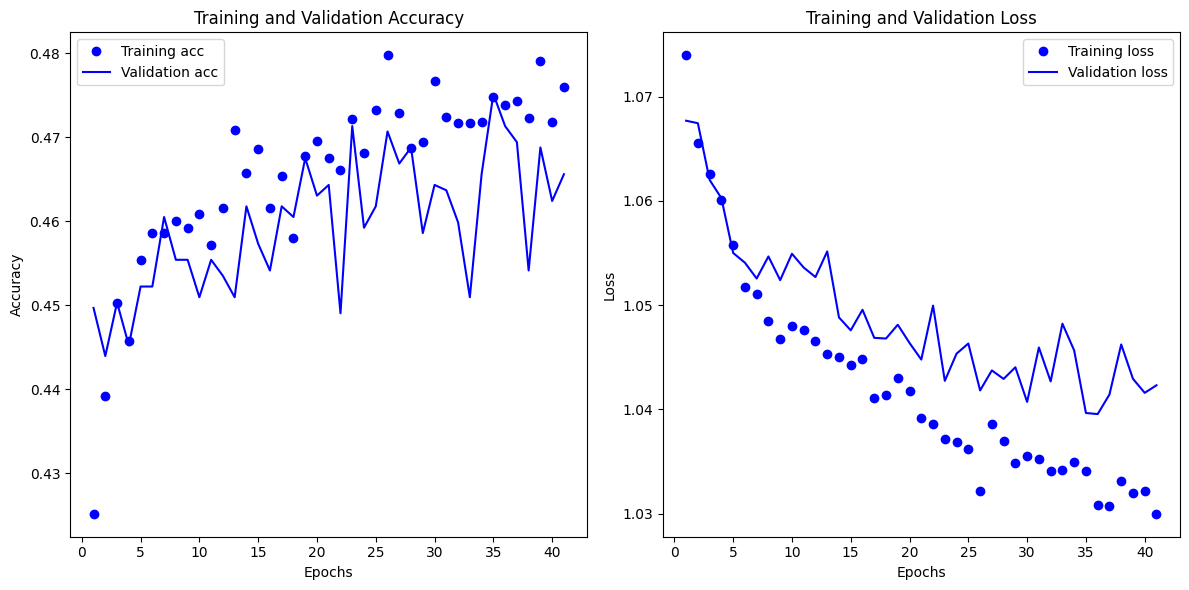

In [20]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable holding the output from the model.fit() call
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Neural Network simple

In [7]:
# Drop NaN values from DataFrame
data.dropna(inplace=True)

# Labeling and scaling
future_window = 10
price_future = data['Close'].shift(-future_window)
data['Label'] = np.where(price_future >= data['Close'] * 1.01, 1,
                         np.where(price_future <= data['Close'] * 0.99, -1, 0))

# Prepare features and labels
X = data[['SMA_9', 'SMA_18', '9>18', 'SMA_50', 'SMA_200', '50>200', 'SAR', 'Close>SAR', 'SMA_10', 'WMA_10', 'Momentum_10', 'Stochastic_K', 'Stochastic_D', 'RSI', 'MACD', 'Williams_R', 'AD_Oscillator', 'CCI']]
y = data['Label']

# Adjust labels to be 0, 1, 2 instead of -1, 0, 1
y = y + 1

# Normalize features
X_scaled = scaler.fit_transform(X.dropna())  # Ensure no NaN values in the features
y = y[X.index]  # Align labels with the features

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Neural network architecture
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 outputs for 3 classes
])

# Compile the model with categorical cross-entropy loss for integer labels
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the adjusted labels
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the adjusted test labels
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/50
154/154 [==============================] - 4s 10ms/step - loss: 1.0705 - accuracy: 0.4381 - val_loss: 1.0717 - val_accuracy: 0.4324
Epoch 2/50
154/154 [==============================] - 1s 8ms/step - loss: 1.0591 - accuracy: 0.4446 - val_loss: 1.0634 - val_accuracy: 0.4194
Epoch 3/50
154/154 [==============================] - 0s 3ms/step - loss: 1.0564 - accuracy: 0.4407 - val_loss: 1.0623 - val_accuracy: 0.4194
Epoch 4/50
154/154 [==============================] - 0s 3ms/step - loss: 1.0532 - accuracy: 0.4436 - val_loss: 1.0592 - val_accuracy: 0.4577
Epoch 5/50
154/154 [==============================] - 0s 2ms/step - loss: 1.0508 - accuracy: 0.4419 - val_loss: 1.0588 - val_accuracy: 0.4471
Epoch 6/50
154/154 [==============================] - 1s 4ms/step - loss: 1.0498 - accuracy: 0.4454 - val_loss: 1.0558 - val_accuracy: 0.4528
Epoch 7/50
154/154 [==============================] - 1s 5ms/step - loss: 1.0470 - accuracy: 0.4542 - val_loss: 1.0597 - val_accuracy: 0.4235
Epoch

In [6]:
# Check the shapes of the datasets
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# Check for NaN values in the datasets
print("NaN in X_train:", np.isnan(X_train).any())
print("NaN in y_train:", np.isnan(y_train).any())

# Check unique values in y_train to ensure they are appropriate for the number of classes and are integers
print("Unique labels in y_train:", np.unique(y_train))

# Data types
print("Data type of X_train:", X_train.dtype)
print("Data type of y_train:", y_train.dtype)


Shape of X_train: (6136, 18)
Shape of y_train: (6136,)
NaN in X_train: False
NaN in y_train: False
Unique labels in y_train: [-1  0  1]
Data type of X_train: float64
Data type of y_train: int64


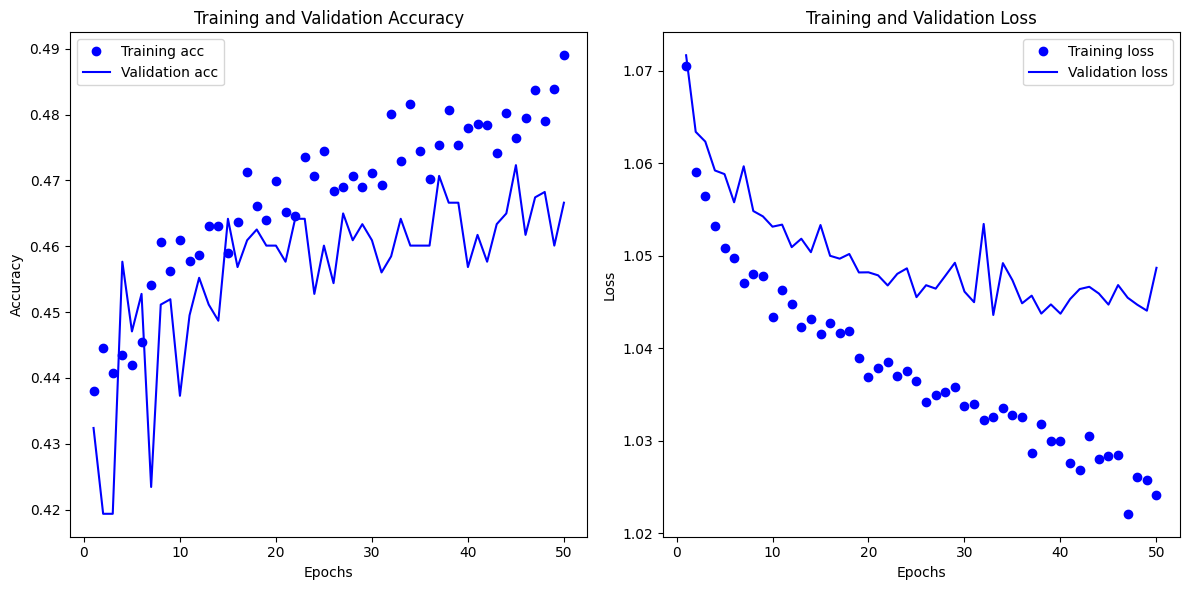

In [8]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable holding the output from the model.fit() call
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
